
... ***CURRENTLY UNDER DEVELOPMENT*** ...



##  Simulate Monthly Mean Sea Level using a multivariate-linear regression model based on the annual SST PCs


inputs required: 
  * Parameters of the linear regression between MMSLA and annual PCs (*from Notebook 01_Offshore/02_TIDES_MMSL_Regression*)
  * Simulated Annual PCs under climate change (*from Notebook 01_01_AWTs_Probability_Change*)

in this notebook:
  * Obtain predicted timeseries of MMSLA based on simulated timeseries of annual PCs 
  

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op
from collections import OrderedDict

# python libs
import numpy as np
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..','..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.util.time_operations import date2yearfrac as d2yf
from teslakit.io.aux_nc import StoreBugXdset

from teslakit.plotting.tides import Plot_MMSL_Histogram, Plot_MMSL_Prediction



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'

# offshore
db = Database(p_data)
db.SetSite('ROI')

# climate change - S4
db_S5 = Database(p_data)
db_S5.SetSite('ROI_CC_S5')


In [3]:
# --------------------------------------
# load data and set parameters

SST_PCs_sim_m = db_S5.Load_SST_PCs_sim_m()  # climate change simulated SST PCs (monthly)
db.Load_TIDE_mmsl_params(model_coefs)       # MMSL non linear regress model coef 


In [4]:
# --------------------------------------
# Predict 1000 years using simulated PCs (monthly time resolution)
sim_params = sim_params['sim_params'].values

# get simulation time as year fractions
PCs_sim_time = SST_PCs_sim_m.time.values[:]
frac_year_sim = np.array([d2yf(x) for x in PCs_sim_time])

# solve each PCs simulation
def modelfun(x, t, pc1, pc2, pc3, y):
    return x[0] + x[1]*pc1 + x[2]*pc2 + x[3]*pc3 + \
            np.array([x[4] + x[5]*pc1 + x[6]*pc2 + x[7]*pc3]).flatten() * np.cos(2*np.pi*t) + \
            np.array([x[8] + x[9]*pc1 + x[10]*pc2 + x[11]*pc3]).flatten() * np.sin(2*np.pi*t) + \
            np.array([x[12] + x[13]*pc1 + x[14]*pc2 + x[15]*pc3]).flatten() * np.cos(4*np.pi*t) + \
            np.array([x[16] + x[17]*pc1 + x[18]*pc2 + x[19]*pc3]).flatten() * np.sin(4*np.pi*t) - y

l_MMSL_sim = []
for s in SST_PCs_sim_m.n_sim:
    
    PCs_s_m = SST_PCs_sim_m.sel(n_sim=s)
    MMSL_PC1_sim = PCs_s_m.PC1.values[:]
    MMSL_PC2_sim = PCs_s_m.PC2.values[:]
    MMSL_PC3_sim = PCs_s_m.PC3.values[:]

    # use non-linear-model
    y_0s = np.zeros(frac_year_sim.shape)
    y_sim = modelfun(sim_params, frac_year_sim, MMSL_PC1_sim, MMSL_PC2_sim, MMSL_PC3_sim, y_0s)

    # append simulated MMSL
    l_MMSL_sim.append(
        xr.Dataset(
            {
                'mmsl' : (('time',), y_sim / 1000),  # mm to m
            },
            {'time' : PCs_sim_time}
        )
    )
    
# concatenate simulations
MMSL_sim = xr.concat(l_MMSL_sim, 'n_sim')
print(MMSL_sim)

db_S5.Save_TIDE_sim_mmsl(MMSL_sim)


<xarray.Dataset>
Dimensions:  (n_sim: 100, time: 12012)
Coordinates:
  * time     (time) object 1999-06-01 00:00:00 ... 3000-05-01 00:00:00
Dimensions without coordinates: n_sim
Data variables:
    mmsl     (n_sim, time) float64 0.01963 -0.01579 -0.0537 ... 0.005171 0.02456


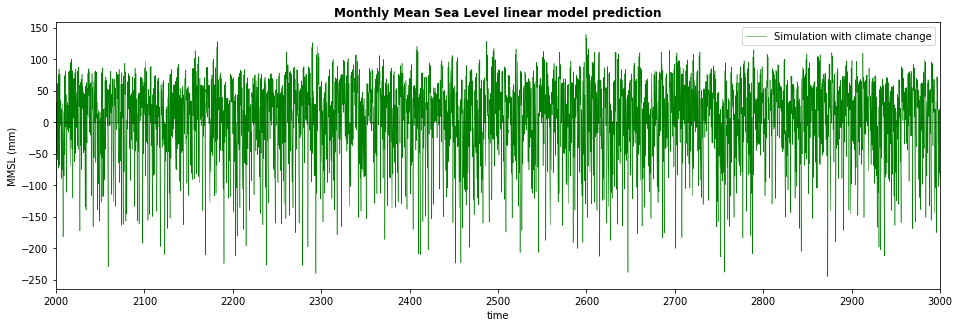

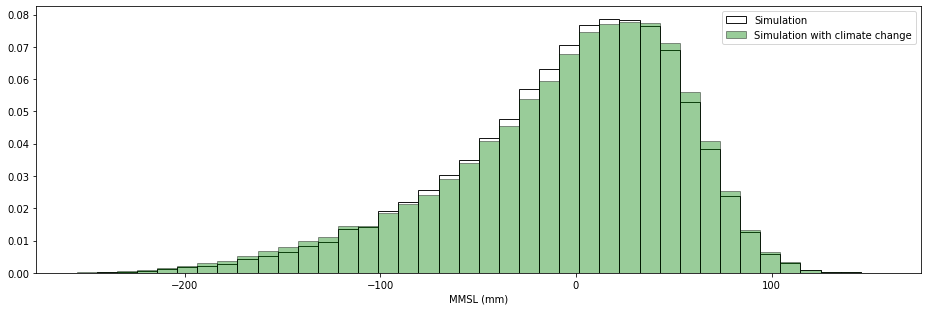

In [3]:
#-----------------------------
# Compare offshore and climate change simulations

# Original offshore MMSL simulations (no climate change)
MMSL_sim_old = db.Load_TIDE_sim_mmsl()

# Plot mmsl prediction (plot_sim=0)
plot_sim = 0

y_sim = MMSL_sim.sel(n_sim=plot_sim).mmsl.values[:] * 1000  # m to mm
t_sim = MMSL_sim.sel(n_sim=plot_sim).time.values[:]
y_p = MMSL_sim_old.sel(n_sim=plot_sim).mmsl.values[:] * 1000  # m to mm

Plot_MMSL_Prediction(t_sim, y_sim, label='Simulation with climate change');

# Plot histogram for all sims
y_p = MMSL_sim_old.mmsl.values[:] * 1000  
y_sim = MMSL_sim.mmsl.values[:] * 1000  

Plot_MMSL_Histogram(y_p.flatten(), y_sim.flatten(), label_1='Simulation', label_2='Simulation with climate change');
